In [8]:
import networkx as nx
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [10]:
plt.rcParams["figure.figsize"] = (20,3)

In [11]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import schema_to_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [12]:
DATASET = DatasetPath('misc-football')
schema = DatasetSchema.load_schema(DATASET.name)
G = schema_to_igraph(schema)

In [13]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [14]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [15]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [16]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [17]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 115
Number of Edges: 1226
Density: 0.1870327993897788


In [18]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [19]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 21.321739130434782
Median Degree: 22.0


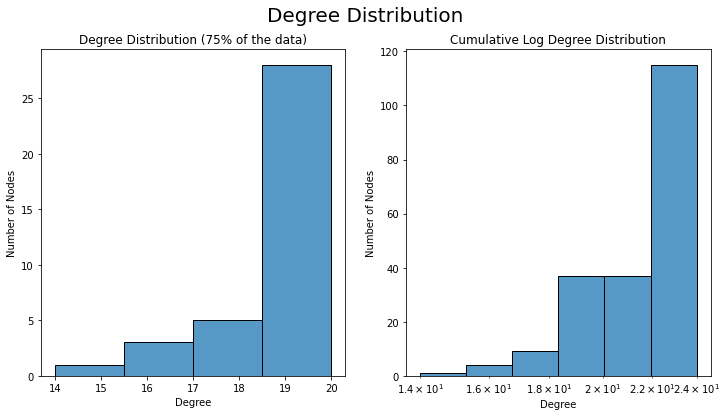

In [20]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [21]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,24,3
1,24,2
2,24,7
3,24,54
4,24,4
5,24,16
6,24,105
7,24,68
8,24,6
9,24,8


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [22]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [23]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.399
Diameter: 4


In [24]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,115.000000,115.000000,115.000000,115.000000,115.000000
mean,0.187033,0.012032,0.091767,0.008696,0.403216
std,0.015569,0.027954,0.016642,0.000576,0.104221
min,0.122807,0.000000,0.048312,0.006269,0.111111
25%,0.175439,0.000000,0.080094,0.008320,0.362374
50%,0.192982,0.001954,0.089921,0.008848,0.400000
75%,0.192982,0.007028,0.104755,0.008990,0.472727
max,0.210526,0.141196,0.127683,0.009677,0.666667


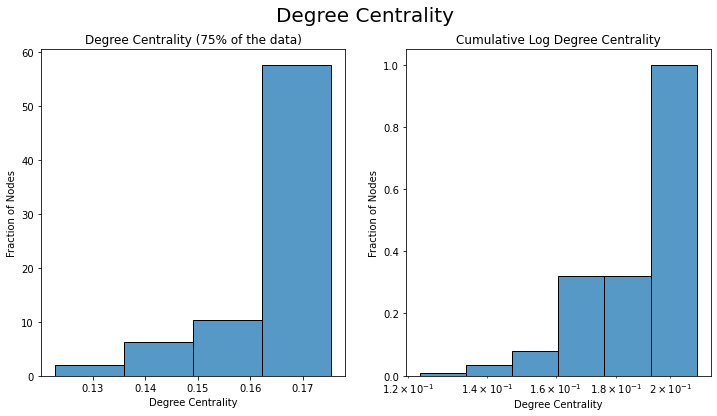

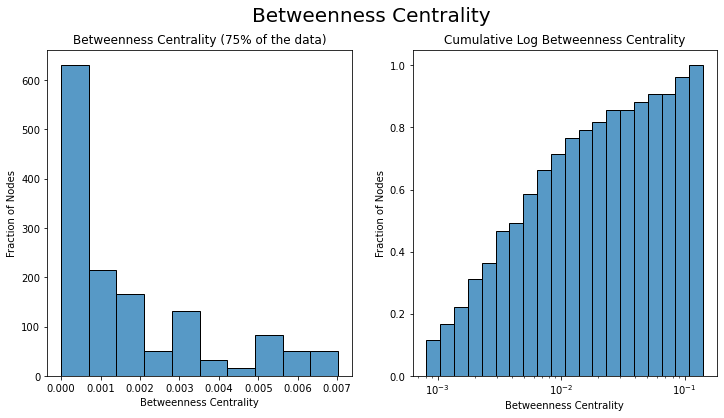

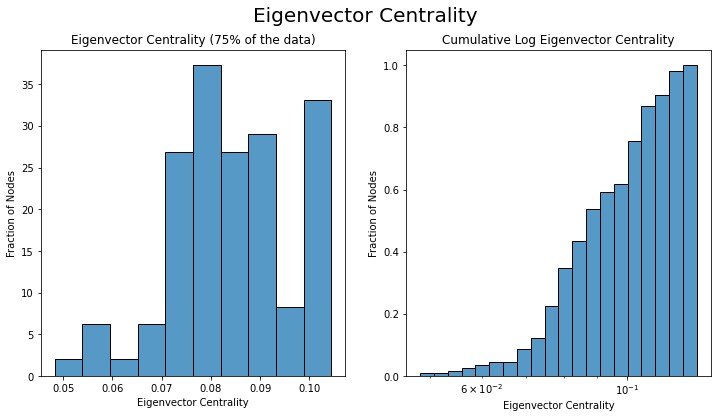

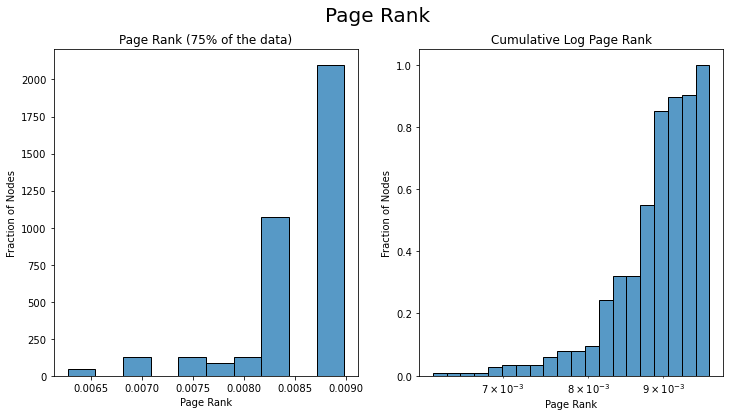

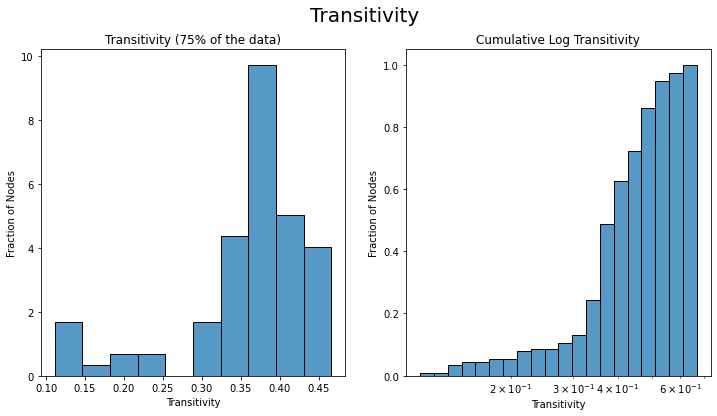

In [25]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [26]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,8,0.141196,26,0.127683,68,0.009677,6,0.666667,106
1,0.210526,68,0.140939,111,0.122577,54,0.009641,2,0.644444,34
2,0.210526,3,0.116033,67,0.121289,89,0.009617,4,0.622222,104
3,0.210526,105,0.101802,85,0.120724,8,0.009588,1,0.600000,95
4,0.210526,1,0.096766,88,0.119902,74,0.009548,7,0.577778,109
5,0.210526,4,0.095883,29,0.119568,47,0.009541,105,0.563636,84
6,0.210526,7,0.086805,51,0.117695,115,0.009510,16,0.545455,50
7,0.210526,2,0.060277,39,0.117246,50,0.009509,3,0.545455,115
8,0.210526,6,0.054013,91,0.116471,84,0.009495,89,0.533333,42
9,0.210526,54,0.048221,70,0.116303,16,0.009491,8,0.527273,38


## Connected Components Statistics

In [27]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 115


Text(0.5, 1.0, 'Connected Components')

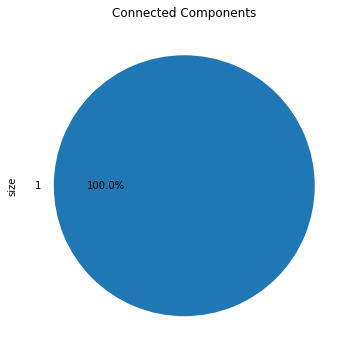

In [28]:
df_tmp = pd.Series(list(map(len, G.components())), name='size', index=range(1,len(G.components())+1))
ax = df_tmp.sort_values(ascending=False).head(30).plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [29]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
Team,Team,115,21.321739,22.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

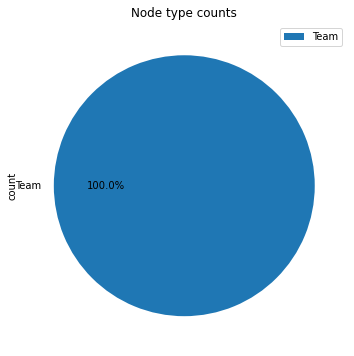

In [30]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

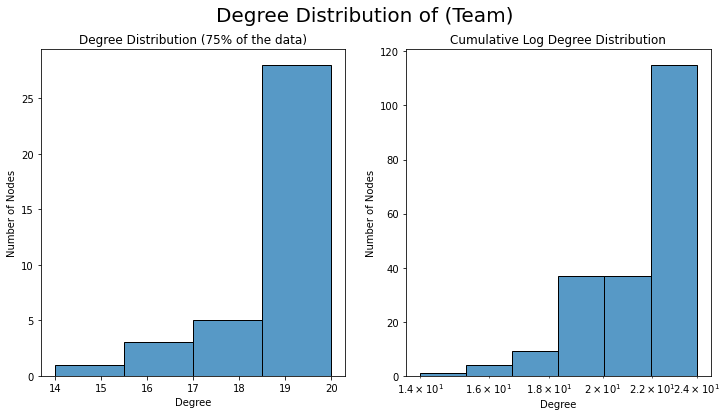

In [31]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [32]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Team)


,value,label
0,24,3
1,24,2
2,24,7
3,24,54
4,24,4
5,24,16
6,24,105
7,24,68
8,24,6
9,24,8


### Edge Type Statistics

In [33]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
PLAYS,PLAYS,1226


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

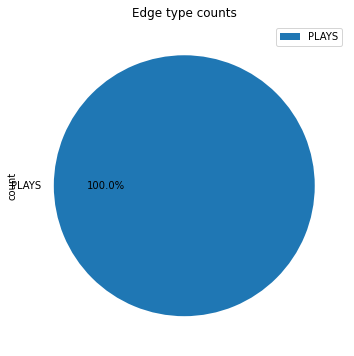

In [34]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [35]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [36]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Team


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,1,0.141196,26,0.127683,68,0.009677,6,0.666667,106
1,0.210526,8,0.140939,111,0.122577,54,0.009641,2,0.644444,34
2,0.210526,68,0.116033,67,0.121289,89,0.009617,4,0.622222,104
3,0.210526,16,0.101802,85,0.120724,8,0.009588,1,0.600000,95
4,0.210526,105,0.096766,88,0.119902,74,0.009548,7,0.577778,109
5,0.210526,2,0.095883,29,0.119568,47,0.009541,105,0.563636,84
6,0.210526,54,0.086805,51,0.117695,115,0.009510,16,0.545455,115
7,0.210526,89,0.060277,39,0.117246,50,0.009509,3,0.545455,50
8,0.210526,7,0.054013,91,0.116471,84,0.009495,89,0.533333,42
9,0.210526,6,0.048221,70,0.116303,16,0.009491,8,0.527273,38


# Clustering

## No Clustering Modularity

In [37]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [38]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.604428518584556
Number of communities: 10


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

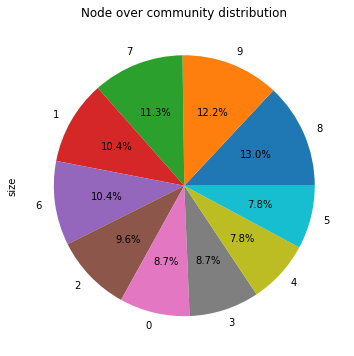

In [39]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [40]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.192982,31,0.026812,31,0.100915,83,0.009006,20,0.600000,95
1,0.192982,81,0.019125,81,0.090415,81,0.008999,30,0.490909,30
2,0.192982,20,0.001984,36,0.088772,56,0.008960,31,0.472727,31
3,0.192982,80,0.001410,80,0.088460,36,0.008959,80,0.472727,80
4,0.192982,56,0.001323,30,0.087550,31,0.008949,81,0.466667,102
5,0.192982,83,0.000992,95,0.086387,80,0.008941,56,0.436364,20
6,0.192982,30,0.000940,56,0.085764,30,0.008940,36,0.436364,36
7,0.192982,36,0.000000,20,0.083485,20,0.008864,83,0.418182,56
8,0.175439,102,0.000000,102,0.081715,102,0.008243,102,0.181818,81
9,0.175439,95,0.000000,83,0.080728,95,0.008243,95,0.145455,83


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,6,0.101802,85,0.106250,4,0.009677,6,0.444444,11
1,0.210526,4,0.019408,4,0.104367,75,0.009617,4,0.422222,53
2,0.192982,85,0.007340,11,0.103321,82,0.008947,99,0.422222,108
3,0.192982,41,0.007018,75,0.102965,41,0.008882,73,0.422222,103
4,0.192982,82,0.005133,82,0.102272,6,0.008881,85,0.381818,85
5,0.192982,73,0.003596,99,0.102143,85,0.008870,41,0.381818,73
6,0.192982,75,0.003001,53,0.100993,73,0.008861,82,0.381818,75
7,0.192982,99,0.003001,108,0.096211,99,0.008853,75,0.363636,6
8,0.175439,53,0.000000,103,0.092862,53,0.008212,11,0.363636,82
9,0.175439,108,0.000000,6,0.091595,108,0.008204,103,0.363636,99


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,16,0.027896,14,0.116303,16,0.009548,7,0.418182,40
1,0.210526,7,0.024424,107,0.116262,3,0.009510,16,0.400000,101
2,0.210526,3,0.001879,33,0.112856,7,0.009509,3,0.400000,107
3,0.192982,65,0.000000,65,0.110053,48,0.008888,61,0.381818,65
4,0.192982,101,0.000000,101,0.109209,33,0.008842,65,0.381818,48
5,0.192982,40,0.000000,16,0.106501,101,0.008838,40,0.381818,61
6,0.192982,48,0.000000,40,0.106450,65,0.008828,14,0.381818,33
7,0.192982,61,0.000000,48,0.105995,14,0.008827,107,0.381818,14
8,0.192982,107,0.000000,61,0.105028,107,0.008825,101,0.378788,3
9,0.192982,33,0.000000,7,0.104385,40,0.008800,33,0.348485,16


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,8,0.015049,79,0.120724,8,0.009491,8,0.577778,109
1,0.192982,78,0.011616,52,0.111198,112,0.008883,79,0.527273,79
2,0.192982,22,0.010213,9,0.110323,23,0.008873,52,0.509091,23
3,0.192982,52,0.009607,69,0.110187,69,0.008844,9,0.472727,78
4,0.192982,112,0.000000,78,0.110067,78,0.008824,69,0.472727,52
5,0.192982,9,0.000000,22,0.109969,22,0.008816,78,0.472727,112
6,0.192982,23,0.000000,112,0.107811,9,0.008813,22,0.472727,9
7,0.192982,69,0.000000,8,0.104305,79,0.008813,23,0.472727,69
8,0.192982,79,0.000000,23,0.104248,52,0.008809,112,0.454545,22
9,0.175439,109,0.000000,109,0.100990,109,0.008123,109,0.393939,8


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,2,0.141196,26,0.096385,2,0.009641,2,0.666667,106
1,0.192982,26,0.014826,90,0.093379,26,0.008981,38,0.644444,34
2,0.192982,38,0.005264,110,0.091472,90,0.008962,110,0.622222,104
3,0.192982,90,0.004929,2,0.090543,46,0.008919,90,0.527273,38
4,0.192982,110,0.002976,34,0.087270,110,0.008918,46,0.527273,110
5,0.192982,46,0.002976,38,0.086034,38,0.008909,26,0.527273,46
6,0.175439,34,0.000992,104,0.083368,34,0.008232,104,0.509091,26
7,0.175439,106,0.000000,106,0.081921,106,0.008225,106,0.509091,90
8,0.175439,104,0.000000,46,0.081745,104,0.008215,34,0.439394,2


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,54,0.140939,111,0.127683,68,0.009495,89,0.563636,84
1,0.210526,68,0.011988,47,0.122577,54,0.009472,54,0.545455,115
2,0.210526,89,0.005403,50,0.121289,89,0.009438,68,0.545455,50
3,0.192982,115,0.003273,74,0.119902,74,0.008777,111,0.527273,47
4,0.192982,111,0.002901,115,0.119568,47,0.008764,84,0.527273,74
5,0.192982,47,0.002232,89,0.117695,115,0.008759,115,0.509091,111
6,0.192982,84,0.002009,68,0.117246,50,0.008755,50,0.484848,68
7,0.192982,50,0.000000,54,0.116471,84,0.008740,47,0.454545,54
8,0.192982,74,0.000000,84,0.114943,111,0.008737,74,0.454545,89


No node timestamp data available


### Label Propagation

In [41]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.5976291285337536
Number of communities: 9


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

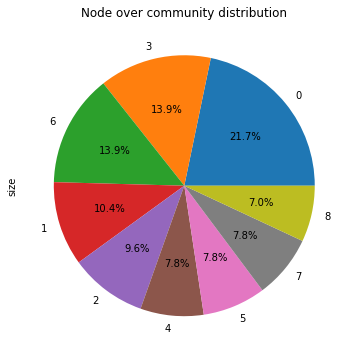

In [42]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [43]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.192982,31,0.060277,39,0.100915,83,0.009144,44,0.600000,95
1,0.192982,80,0.026812,31,0.090415,81,0.009132,19,0.490909,30
2,0.192982,36,0.019125,81,0.088772,56,0.009101,35,0.488889,55
3,0.192982,44,0.002480,27,0.088460,36,0.009069,39,0.472727,80
4,0.192982,30,0.001984,36,0.087550,31,0.009018,32,0.472727,31
5,0.192982,20,0.001932,62,0.086387,80,0.009014,62,0.466667,102
6,0.192982,19,0.001601,44,0.085764,30,0.009006,20,0.444444,72
7,0.192982,83,0.001488,13,0.083485,20,0.008999,30,0.436364,36
8,0.192982,56,0.001410,80,0.082628,62,0.008960,31,0.436364,20
9,0.192982,32,0.001323,30,0.082554,32,0.008959,80,0.422222,100


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,6,0.101802,85,0.106250,4,0.009677,6,0.444444,11
1,0.210526,4,0.019408,4,0.104367,75,0.009617,4,0.422222,53
2,0.192982,85,0.007340,11,0.103321,82,0.008947,99,0.422222,108
3,0.192982,41,0.007018,75,0.102965,41,0.008882,73,0.422222,103
4,0.192982,82,0.005133,82,0.102272,6,0.008881,85,0.381818,85
5,0.192982,73,0.003596,99,0.102143,85,0.008870,41,0.381818,73
6,0.192982,75,0.003001,53,0.100993,73,0.008861,82,0.381818,75
7,0.192982,99,0.003001,108,0.096211,99,0.008853,75,0.363636,6
8,0.175439,53,0.000000,103,0.092862,53,0.008212,11,0.363636,82
9,0.175439,108,0.000000,6,0.091595,108,0.008204,103,0.363636,99


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,16,0.027896,14,0.116303,16,0.009548,7,0.418182,40
1,0.210526,7,0.024424,107,0.116262,3,0.009510,16,0.400000,101
2,0.210526,3,0.001879,33,0.112856,7,0.009509,3,0.400000,107
3,0.192982,65,0.000000,65,0.110053,48,0.008888,61,0.381818,65
4,0.192982,101,0.000000,101,0.109209,33,0.008842,65,0.381818,48
5,0.192982,40,0.000000,16,0.106501,101,0.008838,40,0.381818,61
6,0.192982,48,0.000000,40,0.106450,65,0.008828,14,0.381818,33
7,0.192982,61,0.000000,48,0.105995,14,0.008827,107,0.381818,14
8,0.192982,107,0.000000,61,0.105028,107,0.008825,101,0.378788,3
9,0.192982,33,0.000000,7,0.104385,40,0.008800,33,0.348485,16


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,8,0.095883,29,0.120724,8,0.009491,8,0.577778,109
1,0.192982,78,0.086805,51,0.111198,112,0.009007,70,0.527273,79
2,0.192982,22,0.054013,91,0.110323,23,0.008883,79,0.509091,23
3,0.192982,52,0.048221,70,0.110187,69,0.008873,52,0.472727,78
4,0.192982,112,0.046771,12,0.110067,78,0.008844,9,0.472727,52
5,0.192982,9,0.015049,79,0.109969,22,0.008824,69,0.472727,112
6,0.192982,23,0.011616,52,0.107811,9,0.008816,78,0.472727,9
7,0.192982,69,0.010213,9,0.104305,79,0.008813,22,0.472727,69
8,0.192982,70,0.009607,69,0.104248,52,0.008813,23,0.454545,22
9,0.192982,79,0.000000,78,0.100990,109,0.008809,112,0.393939,8


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,2,0.141196,26,0.096385,2,0.009641,2,0.666667,106
1,0.192982,26,0.014826,90,0.093379,26,0.008981,38,0.644444,34
2,0.192982,38,0.005264,110,0.091472,90,0.008962,110,0.622222,104
3,0.192982,90,0.004929,2,0.090543,46,0.008919,90,0.527273,38
4,0.192982,110,0.002976,34,0.087270,110,0.008918,46,0.527273,110
5,0.192982,46,0.002976,38,0.086034,38,0.008909,26,0.527273,46
6,0.175439,34,0.000992,104,0.083368,34,0.008232,104,0.509091,26
7,0.175439,106,0.000000,106,0.081921,106,0.008225,106,0.509091,90
8,0.175439,104,0.000000,46,0.081745,104,0.008215,34,0.439394,2


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.210526,54,0.140939,111,0.127683,68,0.009495,89,0.563636,84
1,0.210526,68,0.011988,47,0.122577,54,0.009472,54,0.545455,115
2,0.210526,89,0.005403,50,0.121289,89,0.009438,68,0.545455,50
3,0.192982,115,0.003273,74,0.119902,74,0.008777,111,0.527273,47
4,0.192982,111,0.002901,115,0.119568,47,0.008764,84,0.527273,74
5,0.192982,47,0.002232,89,0.117695,115,0.008759,115,0.509091,111
6,0.192982,84,0.002009,68,0.117246,50,0.008755,50,0.484848,68
7,0.192982,50,0.000000,54,0.116471,84,0.008740,47,0.454545,54
8,0.192982,74,0.000000,84,0.114943,111,0.008737,74,0.454545,89


No timestamp data available
